# Module 6 

## 1.Load dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [5]:
df = pd.read_csv(data)

In [6]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## 2. Prepare Dataset

In [7]:
df.nunique()

engine_displacement      36
num_cylinders            14
horsepower              192
vehicle_weight         9704
acceleration            162
model_year               24
origin                    3
fuel_type                 2
drivetrain                2
num_doors                 9
fuel_efficiency_mpg    9704
dtype: int64

In [8]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [9]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
df = df.fillna(0)

In [11]:
df_fulltrain, df_test = train_test_split(df,           test_size=0.2, random_state=1)
df_train,     df_val  = train_test_split(df_fulltrain, test_size=0.25,random_state=1)

In [12]:
df_train= df_train.reset_index(drop=True)
df_val  = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train= df_train['fuel_efficiency_mpg'].values
y_val  = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

In [14]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [15]:
train_dicts= df_train.to_dict(orient='records')
val_dicts  = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [16]:
X_train = dv.fit_transform(train_dicts)
X_val   = dv.transform(val_dicts)

## 3.Decision Tree

In [17]:
dt = DecisionTreeRegressor(max_depth=1)

In [18]:
dt.fit(X_train,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [19]:
export_text(dt, feature_names=list(dv.get_feature_names_out()))

'|--- vehicle_weight <= 3022.11\n|   |--- value: [16.88]\n|--- vehicle_weight >  3022.11\n|   |--- value: [12.94]\n'

In [20]:
y_pred = dt.predict(X_val)

In [21]:
error = np.sqrt(mean_squared_error(y_val,y_pred))

In [22]:
error

np.float64(1.6104639028827588)

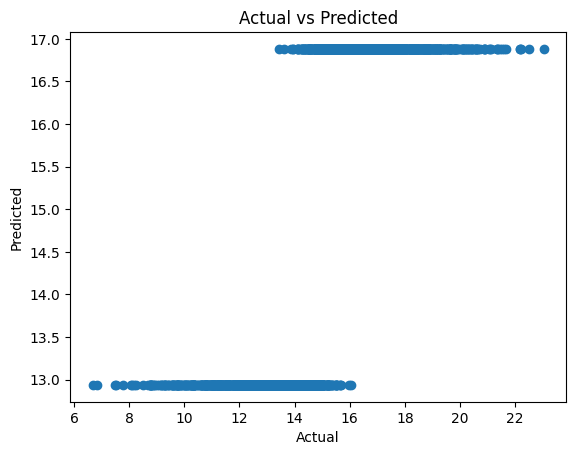

In [23]:
plt.scatter(y_val, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

## 4.Random forest

In [24]:
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred))
    print(n,rmse.round(3))

10 0.457
20 0.452
30 0.45
40 0.448
50 0.446
60 0.445
70 0.445
80 0.445
90 0.444
100 0.444
110 0.443
120 0.443
130 0.443
140 0.443
150 0.442
160 0.442
170 0.442
180 0.442
190 0.442
200 0.442


In [25]:
max_depth = [10, 15, 20, 25]
no_estimators = np.arange(10,201,10)
scores=[]
for d in max_depth:
    rmse_scores=[]
    for n in no_estimators:
        rf = RandomForestRegressor(max_depth=d,n_estimators=n,random_state=1,n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val,y_pred))
        rmse_scores.append(rmse)
    scores.append((d,np.mean(rmse_scores)))


In [26]:
scores_df=pd.DataFrame(scores,columns=['max_depth','rmse'])

In [27]:
scores_df

,max_depth,rmse
0,10,0.441774
1,15,0.445024
2,20,0.445955
3,25,0.445408


## 5. Feature importance

In [28]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
importances = rf.feature_importances_
info=[]
for name, importance in zip(dv.get_feature_names_out(), importances):
    info.append((name, importance))

info_df =pd.DataFrame(info,columns=['name','importance'])
info_df.sort_values('importance',ascending=False)

,name,importance
13,vehicle_weight,0.959176
6,horsepower,0.016042
0,acceleration,0.011454
3,engine_displacement,0.003282
7,model_year,0.003165
8,num_cylinders,0.002331
9,num_doors,0.001628
12,origin=USA,0.000565
11,origin=Europe,0.000494
10,origin=Asia,0.000485


## 6. XGBOOST

In [30]:
!pip install xgboost
import xgboost as xgb

In [33]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train,label= y_train,feature_names=features)
dval = xgb.DMatrix(X_val,label= y_val,feature_names=features)


In [40]:
score =[]
for eta in [0.1,1,0.3]:
    xgb_params ={
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
    xgb_model = xgb.train(xgb_params,dtrain,num_boost_round=100)
    y_pred = xgb_model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred))
    score.append((eta,rmse))

In [41]:
print(score)

[(0.1, np.float64(0.42622800553359225)), (1, np.float64(0.5580586491733865)), (0.3, np.float64(0.45017755678087246))]
